# Recommender System using ALS Algorithm

import libraries and initialize spark session

In [1]:
#import libraries
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col, sum
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# initalize SparkSession
spark = SparkSession.builder.getOrCreate()

# read data
df_business = spark.read.json("C:/Users/juanmao/Downloads/data/yelp_academic_dataset_business.json")
df_review = spark.read.json("C:/Users/juanmao/Downloads/data/yelp_academic_dataset_review.json")


plot top 10 cities with the most reviews

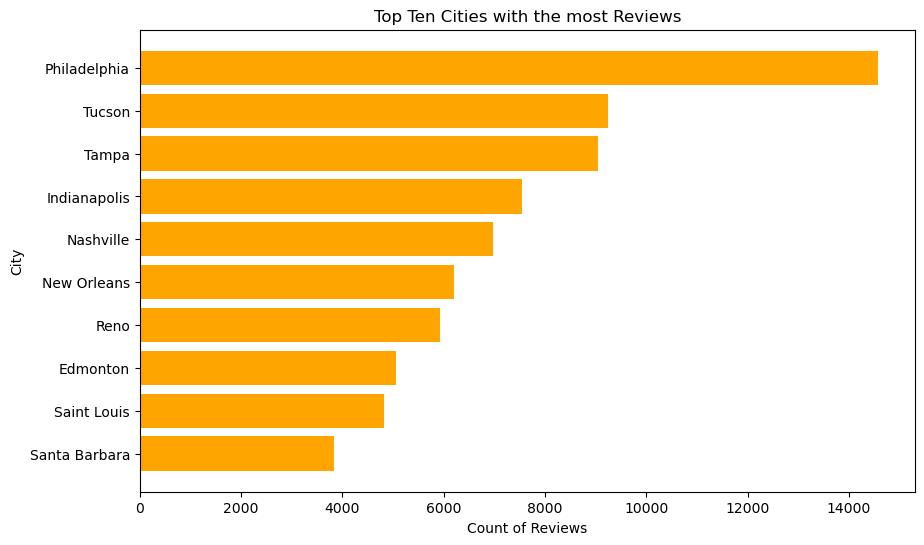

In [14]:
# group by city and count the number of businesses in each city
city_counts_df = df_business.groupBy("city").count()

# order by count in descending order and limit to top ten cities
top_ten_cities = city_counts_df.orderBy(col("count").desc()).limit(10)

# convert to Pandas DataFrame for plotting
top_ten_cities_pd = top_ten_cities.toPandas()

# plotting
plt.figure(figsize=(10, 6))
plt.barh(top_ten_cities_pd["city"], top_ten_cities_pd["count"], color="orange")
plt.xlabel("Count of Reviews")
plt.ylabel("City")
plt.title("Top Ten Cities with the most Reviews")
plt.gca().invert_yaxis()  # Invert y-axis to have the city with the highest count on top
plt.show()


plot top 10 categories

+----------------+-----+
|        category|count|
+----------------+-----+
|     Restaurants|52268|
|            Food|27781|
|        Shopping|24395|
|   Home Services|14356|
|   Beauty & Spas|14292|
|       Nightlife|12281|
|Health & Medical|11890|
|  Local Services|11198|
|            Bars|11065|
|      Automotive|10773|
+----------------+-----+
only showing top 10 rows



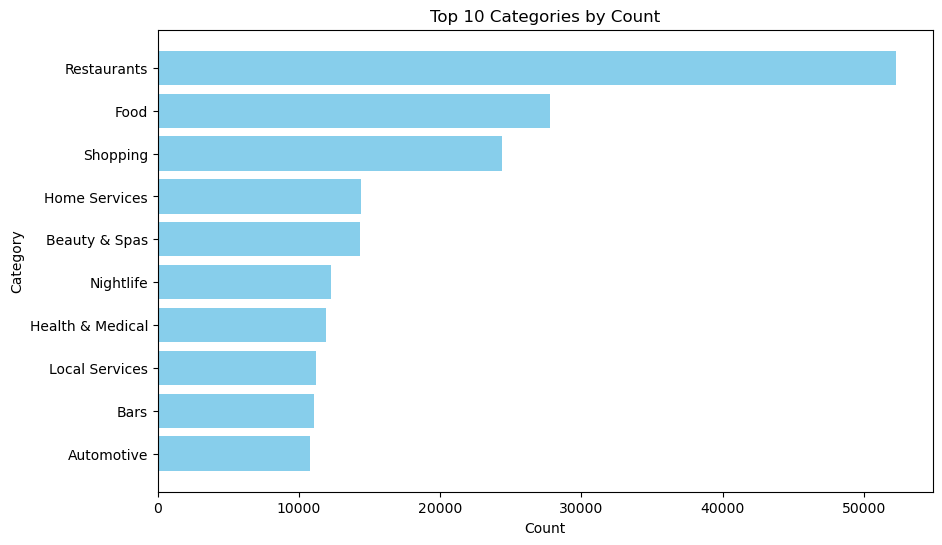

In [4]:
from pyspark.sql.functions import explode, split, trim

# Split category strings and convert them into separate lines.
categories_df = df_business.withColumn("category", explode(split("categories", ", ")))

# Calculate the number of businesses for each category.
category_counts = categories_df.groupBy("category").count()

# Sort in descending order by quantity.
popular_categories = category_counts.orderBy("count", ascending=False)

# Display the top 10 most popular categories.
popular_categories.show(10)


# retrieve the top ten categories
top_ten_categories = popular_categories.orderBy("count", ascending=False).limit(10).toPandas()

# plotting
plt.figure(figsize=(10, 6))
plt.barh(top_ten_categories["category"], top_ten_categories["count"], color="skyblue")
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Top 10 Categories by Count")
plt.gca().invert_yaxis()  # Invert y-axis to have the category with the highest count on top
plt.show()


based on the above information, we choose city named Philadelphia and Restaurants included in categories for analysis

In [2]:
# read data
df_business = spark.read.json("C:/Users/juanmao/Downloads/data/yelp_academic_dataset_business.json")
df_review = spark.read.json("C:/Users/juanmao/Downloads/data/yelp_academic_dataset_review.json")

# select certain columns
df_business = df_business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city").withColumnRenamed("stars", "stars_restaurant")

# choose city named Philadelphia and Restaurants included in the categories for analysis
df_business = df_business.filter((df_business['city'] == 'Philadelphia') & (df_business.categories.contains('Restaurants'))).drop('city')

# left outer join two dataframe on business_id
df_review = df_business.join(df_review, on='business_id', how='left_outer')

# show some rows of df_review
df_review.select(['business_id', 'user_id', 'stars']).show()


+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|0CEUpFtaKhxbmrbSd...|rzab74qbT1lwr_Err...|  4.0|
|0CEUpFtaKhxbmrbSd...|gtpyMiC9M6l5fixvW...|  1.0|
|0CEUpFtaKhxbmrbSd...|XTUm8-HTkNUmD6mdQ...|  2.0|
|0CEUpFtaKhxbmrbSd...|GJuI9s5YPTmutFUuQ...|  1.0|
|0CEUpFtaKhxbmrbSd...|-vew9WvGgY8yJsy8c...|  4.0|
|0CEUpFtaKhxbmrbSd...|NLeT063_JZ5cBvXbD...|  2.0|
|0CEUpFtaKhxbmrbSd...|0_JgP1MtXNRJPxHMd...|  5.0|
|0CEUpFtaKhxbmrbSd...|dnU035RTP5ziF824c...|  5.0|
|0CEUpFtaKhxbmrbSd...|MeShmkMadNwtQHsZU...|  1.0|
|0CEUpFtaKhxbmrbSd...|8Ha9XNqapSQ69d5qz...|  3.0|
|0CEUpFtaKhxbmrbSd...|erZ02s3ePp4aeuPs9...|  5.0|
|0CEUpFtaKhxbmrbSd...|e_p30nCrBysP7tHnr...|  5.0|
|0CEUpFtaKhxbmrbSd...|6ULWXgDTwp-d91927...|  1.0|
|0CEUpFtaKhxbmrbSd...|DmlRFoBlJKNYOk9y0...|  2.0|
|0CEUpFtaKhxbmrbSd...|IfbPU2wVibtfZrQK3...|  5.0|
|0CEUpFtaKhxbmrbSd...|_5V1ZYmeJy1b0Y46s...|  4.0|
|0CEUpFtaKhxbmrbSd...|CgYv_B9LS33Yh9KtR...|  1.0|


Exploratory Data Analysis

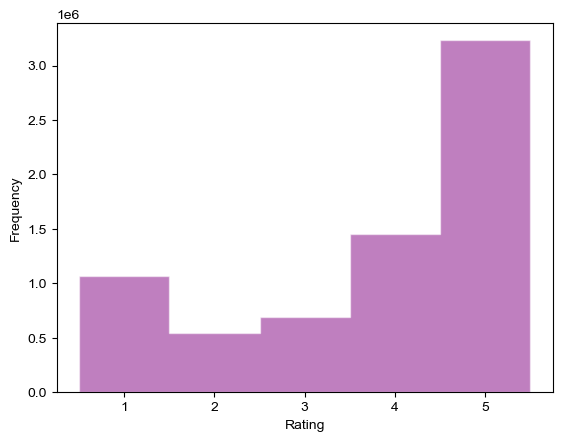

In [2]:
#show the 
reviews = df_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='purple',
         edgecolor='white')
plt.ylabel('Frequency')
plt.xlabel('Rating')
sns.set_style("white")


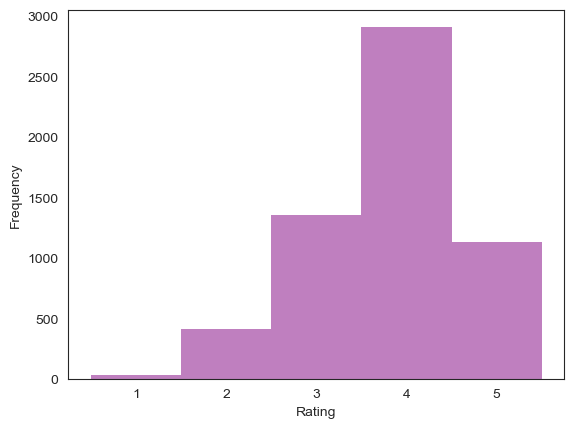

In [3]:
restaurant_reviews = df_business.select('stars_restaurant').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]


plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='purple',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
sns.set_style("white")


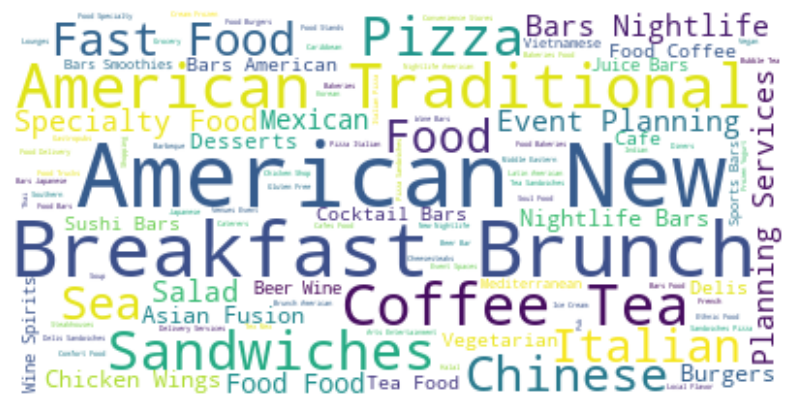

In [4]:
restaurant_categories = df_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]
text = " ".join(review for review in restaurant_categories_list)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('food', "")


# generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [3]:
from pyspark.sql.functions import monotonically_increasing_id

# extract unique users_ids from the data
users = df_review.select("user_id").distinct().coalesce(1)
# create a unique numerical id corresponding to the user_id
users = users.withColumn("userId", monotonically_increasing_id()).persist()
users.show()


+--------------------+------+
|             user_id|userId|
+--------------------+------+
|Xdjva5cC09Z1tgqUi...|     0|
|dBh9VbJy8fFInIxKS...|     1|
|FYdno_pQaIhow_H_9...|     2|
|wZWB41wmnv4pPsetu...|     3|
|YPI7NEnYpIFEvNQ1y...|     4|
|s3J9mcm_7Xl0a6Cb0...|     5|
|bHPpSsGbFM9BxwiG3...|     6|
|UvGrtngH9e8MFhaWz...|     7|
|FlXBpK_YZxLo27jcM...|     8|
|b35seJisMClGvyfnY...|     9|
|CMOgZ0Y-By6LKHI-z...|    10|
|jxac2pQOPQvYY32Zk...|    11|
|LnFIWZM_l__4t8Qxj...|    12|
|ZcFdoJtKXCgLU2VPA...|    13|
|QtkpyV2NJtYBLouWN...|    14|
|yvDDyApXeKFzrRcX1...|    15|
|pJJWik3FC9USFTICg...|    16|
|7NyerV7a3CsvYC20i...|    17|
|rJfisLX002c1tTVVm...|    18|
|hucM0KSfyv8RScLtU...|    19|
+--------------------+------+
only showing top 20 rows



In [4]:
# extract unique business_ids from the data
business = df_review.select("business_id").distinct().coalesce(1) 
# create a unique numerical id corresponding to the business_id
business = business.withColumn("businessId", monotonically_increasing_id()).persist()
business.show()


+--------------------+----------+
|         business_id|businessId|
+--------------------+----------+
|nBr6NgqcZz1GhtAng...|         0|
|dE_MaaYrXBAEebtH2...|         1|
|Ryt1Fhgz7sixMQSJi...|         2|
|skW4boArIApRw9DXK...|         3|
|pP4q0Mym-qt20nRqT...|         4|
|RI33oswGDkIsc0fuQ...|         5|
|4SQ5uczVt66-GGGeN...|         6|
|4i1to26tzHGWDpquE...|         7|
|MTSW4McQd7CbVtyjq...|         8|
|fKDV_dlDhXd7P5kZi...|         9|
|hwXDlBJdtr1cFFM8s...|        10|
|lqBurWf5LxIhUQ0Ht...|        11|
|4NjPz9bJzll1FMIi2...|        12|
|1pkuCWlH3iEuUAQVH...|        13|
|c6DUOuLuX8pKVNgKU...|        14|
|46_2e1hnQ4csLrYnh...|        15|
|y1HgVnt4K5owmYXC5...|        16|
|DOl21AqtT74dUZ3kv...|        17|
|dIwOZoxwSpPUV3eMY...|        18|
|O1oZpbZNDMH_gz8Dh...|        19|
+--------------------+----------+
only showing top 20 rows



In [5]:
# join the ratings, users and business dataframes
transformed = df_review.join(users, "user_id", "left").join(business, "business_id", "left")
transformed = transformed.select("business_id", "user_id","name","businessId","userId","stars")

transformed.show()


+--------------------+--------------------+------+----------+------+-----+
|         business_id|             user_id|  name|businessId|userId|stars|
+--------------------+--------------------+------+----------+------+-----+
|0CEUpFtaKhxbmrbSd...|rzab74qbT1lwr_Err...|Acadia|        21| 53980|  4.0|
|0CEUpFtaKhxbmrbSd...|gtpyMiC9M6l5fixvW...|Acadia|        21|178743|  1.0|
|0CEUpFtaKhxbmrbSd...|XTUm8-HTkNUmD6mdQ...|Acadia|        21| 90091|  2.0|
|0CEUpFtaKhxbmrbSd...|GJuI9s5YPTmutFUuQ...|Acadia|        21|  1358|  1.0|
|0CEUpFtaKhxbmrbSd...|-vew9WvGgY8yJsy8c...|Acadia|        21| 37822|  4.0|
|0CEUpFtaKhxbmrbSd...|NLeT063_JZ5cBvXbD...|Acadia|        21|  1191|  2.0|
|0CEUpFtaKhxbmrbSd...|0_JgP1MtXNRJPxHMd...|Acadia|        21|143239|  5.0|
|0CEUpFtaKhxbmrbSd...|dnU035RTP5ziF824c...|Acadia|        21| 36863|  5.0|
|0CEUpFtaKhxbmrbSd...|MeShmkMadNwtQHsZU...|Acadia|        21| 36723|  1.0|
|0CEUpFtaKhxbmrbSd...|8Ha9XNqapSQ69d5qz...|Acadia|        21|124944|  3.0|
|0CEUpFtaKhxbmrbSd...|erZ

In [6]:
 transformed= transformed.limit(10000)

(training, test) = transformed.randomSplit([0.8, 0.2])


### Alternating Least Square Algorithm (ALS)

In [7]:
# ALS model1
als=ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="userId",
        itemCol="businessId",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model=als.fit(training)


In [8]:
from pyspark.ml.evaluation import RegressionEvaluator

# initialize evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")

# make prediction with training set
predictions = model.transform(transformed)

# compute RMSE
rmse = evaluator.evaluate(predictions)

# print RMSE
print("RMSE = ", rmse)


RMSE =  0.5257834401837426


In [11]:
# ALS model2
als2=ALS(maxIter=5,
        regParam=0.02,
        rank=25,
        userCol="userId",
        itemCol="businessId",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model2=als2.fit(training)

from pyspark.ml.evaluation import RegressionEvaluator

# initialize evaluator
evaluator2 = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")

# make prediction with training set
predictions = model2.transform(transformed)

# compute RMSE
rmse2 = evaluator2.evaluate(predictions)

# print RMSE
print("RMSE = ", rmse2)


RMSE =  0.670250878923345


In [12]:
# ALS model3
als3=ALS(maxIter=5,
        regParam=0.02,
        rank=30,
        userCol="userId",
        itemCol="businessId",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model3=als3.fit(training)

from pyspark.ml.evaluation import RegressionEvaluator

# initialize evaluator
evaluator3 = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")

# make prediction with training set
predictions = model3.transform(transformed)

# compute RMSE
rmse3 = evaluator3.evaluate(predictions)

# print RMSE
print("RMSE = ", rmse3)


RMSE =  0.6863478818810479


In [9]:
# ALS model4
als4=ALS(maxIter=10,
        regParam=0.02,
        rank=25,
        userCol="userId",
        itemCol="businessId",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model4=als4.fit(training)

from pyspark.ml.evaluation import RegressionEvaluator

# initialize evaluator
evaluator4 = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")

# make prediction with training set
predictions = model4.transform(transformed)

# compute RMSE
rmse4 = evaluator4.evaluate(predictions)

# print RMSE
print("RMSE = ", rmse4)


RMSE =  0.5418695181393898


## Visualize Recommendations

In [15]:
# get the recommendation list of userId=28
user_id = 28

# get all users' recommendation lists
user_recommendations = model.recommendForAllUsers(10)

# explode recommendation lists
user_recommendations_exploded = user_recommendations.filter(user_recommendations.userId == user_id) \
    .selectExpr("userId", "explode(recommendations) as recommendation")

# extract businessId of the restaurants for the user
recommendations_df = user_recommendations_exploded.select(
    "userId", 
    "recommendation.businessId", 
    "recommendation.rating")

# show top 10 recommended restaurants for the user
recommendations_df.show(truncate=False)


+------+----------+---------+
|userId|businessId|rating   |
+------+----------+---------+
|28    |7         |7.8656654|
|28    |4177      |7.5252857|
|28    |4565      |7.191965 |
|28    |4567      |6.042824 |
|28    |2306      |5.9435773|
|28    |3403      |5.267071 |
|28    |2316      |5.245703 |
|28    |5657      |5.239297 |
|28    |1901      |4.804772 |
|28    |1922      |4.63446  |
+------+----------+---------+



In [28]:
# avoid naming conflict
recommendations_df = recommendations_df.withColumnRenamed("userId", "selected_userId")

# join DataFrame
info_recommendation = recommendations_df.join(transformed, on='businessId', how='left_outer') \
    .select(recommendations_df["businessId"], 
            col("selected_userId"),
            col("name"),
            col("rating"))

final_info = info_recommendation.dropDuplicates()

# show outcomes
final_info.orderBy(col("rating").desc()).show()


+----------+---------------+--------------------+---------+
|businessId|selected_userId|                name|   rating|
+----------+---------------+--------------------+---------+
|         7|             28|     Lee's Breakfast|7.8656654|
|      4177|             28|   Nafi Food Express|7.5252857|
|      4565|             28|  Under the Oak Café| 7.191965|
|      4567|             28|        Cafe Couleur| 6.042824|
|      2306|             28|     Maxi Gastronome|5.9435773|
|      3403|             28|     Frog Commissary| 5.267071|
|      2316|             28|       Ocean Harmony| 5.245703|
|      5657|             28|American Express ...| 5.239297|
|      1901|             28|       Strangelove's| 4.804772|
|      1922|             28|Cassava North Ame...|  4.63446|
+----------+---------------+--------------------+---------+

